For data, please check:
https://www.kaggle.com/arashnic/marketing-seris-customer-lifetime-value?select=squark_automotive_CLV_training_data.csv

In [27]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

df_orig = pd.read_csv('./squark_automotive_CLV_training_data.csv')
df_orig.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274.0,...,5.0,0.0,1.0,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0.0,...,42.0,0.0,8.0,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767.0,...,38.0,0.0,2.0,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0.0,...,65.0,0.0,7.0,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836.0,...,44.0,0.0,1.0,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [6]:
df_orig.shape

(9134, 24)

We have 9134 entries.
Anonymous customer id's are certainly not features. 'Custom Lifetime Value' is the target we want to learn. so 22 features.
First, check how many NaN's are there.

In [2]:
for column in df_orig.columns:
    print((column + ' has  ' + str(df_orig[column].isnull().sum())+' NaN'))

Customer has  1035 NaN
State has  1035 NaN
Customer Lifetime Value has  1035 NaN
Response has  1035 NaN
Coverage has  1035 NaN
Education has  1035 NaN
Effective To Date has  1035 NaN
EmploymentStatus has  1035 NaN
Gender has  1035 NaN
Income has  1035 NaN
Location Code has  1035 NaN
Marital Status has  1035 NaN
Monthly Premium Auto has  1035 NaN
Months Since Last Claim has  1035 NaN
Months Since Policy Inception has  1035 NaN
Number of Open Complaints has  1035 NaN
Number of Policies has  1035 NaN
Policy Type has  1035 NaN
Policy has  1035 NaN
Renew Offer Type has  1035 NaN
Sales Channel has  1035 NaN
Total Claim Amount has  1035 NaN
Vehicle Class has  1035 NaN
Vehicle Size has  1035 NaN


It appears that all features have the same number of NaN's. 
For now I just drop them.

In [7]:
df_no_nan = df_orig.dropna()
X_no_nan = df_no_nan.drop(['Customer Lifetime Value'], axis=1)
Y_no_nan = df_no_nan['Customer Lifetime Value']

Next thing: distinguish categorical features and numerical features, and decide a policy to deal with them.

In [8]:
for column in X_no_nan.columns:
    print(column + ' has ' + str(X_no_nan[column].unique().size)+ ' '+str(X_no_nan[column].dtypes) + ' values')

Customer has 8099 object values
State has 5 object values
Response has 2 object values
Coverage has 3 object values
Education has 5 object values
Effective To Date has 59 object values
EmploymentStatus has 5 object values
Gender has 2 object values
Income has 5090 float64 values
Location Code has 3 object values
Marital Status has 3 object values
Monthly Premium Auto has 197 float64 values
Months Since Last Claim has 36 float64 values
Months Since Policy Inception has 100 float64 values
Number of Open Complaints has 6 float64 values
Number of Policies has 9 float64 values
Policy Type has 3 object values
Policy has 9 object values
Renew Offer Type has 4 object values
Sales Channel has 4 object values
Total Claim Amount has 4534 float64 values
Vehicle Class has 6 object values
Vehicle Size has 3 object values


It seems that we do not have categorical features with more than 10 options. so One-Hot Encoder should work.
'Response' and 'Gender' are boolean, so converted to 0 and 1.
For numerical features we use standard normalizer.
However, the date feature 'Effective To Date' needs to be converted as well (unix time is used here, maybe not optimal)

In [15]:
X_no_nan['Response'] = (df_no_nan['Response'] == 'Yes').astype(int)
X_no_nan['Gender'] = (X_no_nan['Gender'] == 'M').astype(int)

obj_cols = [col for col in X_no_nan.columns if X_no_nan[col].dtypes == 'object' and X_no_nan[col].nunique()< 10]

X_no_nan['Effective To Date'] = pd.to_datetime(df_no_nan['Effective To Date'], format = '%m/%d/%Y')
X_no_nan['Effective To Date'] = X_no_nan['Effective To Date'].astype('int64') /  10**9

num_cols = [col for col in X_no_nan.columns if X_no_nan[col].dtypes in ['int32','int64', 'float64']]

For safety, check how many features we have after all the trouble.

In [16]:
len(num_cols) + len(obj_cols)

22

Now be prepared to learn.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(), obj_cols),
)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

y_no_nan = df_no_nan['Customer Lifetime Value']

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_no_nan, y_no_nan, train_size = 0.8, test_size = 0.2, random_state = 0)

X_train_proc = preprocessor.fit_transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)

In [19]:
X_train_proc.shape

(6479, 63)

In [20]:
X_valid_proc.shape

(1620, 63)

Set up a dataframe for the results

In [21]:
res_df = pd.DataFrame(columns = ['Method', 'MAE'])

First, check what is the MAE loss if we blindly guess with the average value of the training set on validation data. This will be the baseline for accuracy comparison.

In [22]:
y_baseline = np.zeros(y_valid.shape)+y_train.mean()

from sklearn.metrics import mean_absolute_error
baseline = mean_absolute_error(y_valid, y_baseline)
print(baseline)

4358.249879597504


In [23]:
res_df = res_df.append({'Method': 'Mean Blind Guess', 'MAE': baseline}, ignore_index=True)

Next we shall use the ordinary multivariate linear regression on the data. Straightforward.

In [24]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

regr.fit(X_train_proc, y_train)
pred_lin = regr.predict(X_valid_proc)
mae_linear = mean_absolute_error(y_valid, pred_lin)
print(mae_linear)

3924.3048012450618


In [25]:
res_df = res_df.append({'Method': 'Multivariate Linear Reg', 'MAE': mae_linear}, ignore_index=True)

The third thing we do is the neuron network.
We begin with a simple 3-layer network, then increase the degree of complexity.

Minimum Validation Loss: 3423.1277


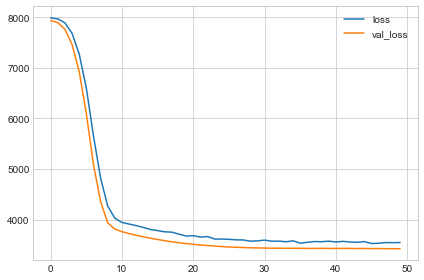

In [28]:
input_shape = [X_train_proc.shape[1]]

model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape = input_shape),
    layers.Dropout(0.2),
    layers.Dense(25, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(
    optimizer = 'adam',
    loss = 'mae'
)

history = model.fit(
    X_train_proc, y_train,
    validation_data = (X_valid_proc, y_valid),
    batch_size = 128,
    epochs = 50,
    verbose = 0,

)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [29]:
mae_3layerNN = history_df['val_loss'].min()
res_df = res_df.append({'Method': 'NN (3 layers)', 'MAE': mae_3layerNN}, ignore_index=True)

In [30]:
res_df

,Method,MAE
0,Mean Blind Guess,4358.249880
1,Multivariate Linear Reg,3924.304801
2,NN (3 layers),3423.127686


Still not very good. Lets check what happens when the complexity increases.

Minimum Validation Loss: 3428.7493


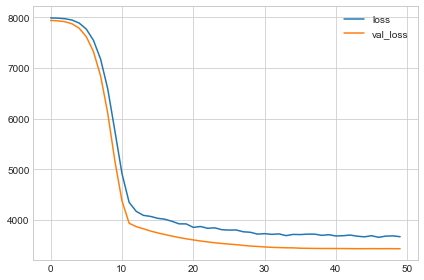

In [31]:
model_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape = input_shape),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(16,activation=  'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_2.compile(
    optimizer = 'adam',
    loss = 'mae'
)

history_2 = model_2.fit(
    X_train_proc, y_train,
    validation_data = (X_valid_proc, y_valid),
    batch_size = 512,
    epochs = 50,
    verbose = 0,

)

history_df_2 = pd.DataFrame(history_2.history)
history_df_2.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df_2['val_loss'].min()))

mae_4layerNN = history_df_2['val_loss'].min()

In [32]:
res_df = res_df.append({'Method': 'NN (4 layers)', 'MAE': mae_4layerNN}, ignore_index=True)

In [33]:
res_df

,Method,MAE
0,Mean Blind Guess,4358.249880
1,Multivariate Linear Reg,3924.304801
2,NN (3 layers),3423.127686
3,NN (4 layers),3428.749268


Still not ideal. Let's do more.

Minimum Validation Loss: 1914.3646


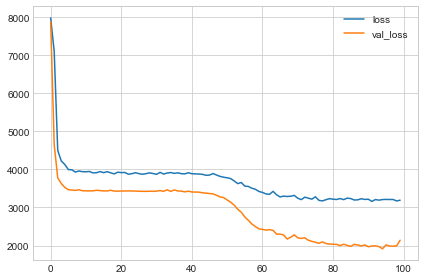

In [34]:
model_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape = input_shape),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_3.compile(
    optimizer = 'adam',
    loss = 'mae'
)

history_3 = model_3.fit(
    X_train_proc, y_train,
    validation_data = (X_valid_proc, y_valid),
    batch_size = 128,
    epochs = 100,
    verbose = 0,

)

history_df_3 = pd.DataFrame(history_3.history)
history_df_3.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df_3['val_loss'].min()))

mae_6layerNN = history_df_3['val_loss'].min()

In [35]:
res_df = res_df.append({'Method': 'NN (6 layers)', 'MAE': mae_6layerNN}, ignore_index=True)

A lot better now. Let's check the residuals.

(0.0, 70000.0)

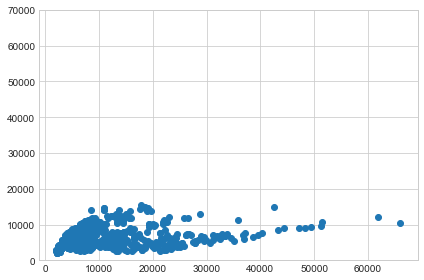

In [36]:
plt.scatter(y_valid, model.predict(X_valid_proc))
plt.ylim(0,70000)

(0.0, 70000.0)

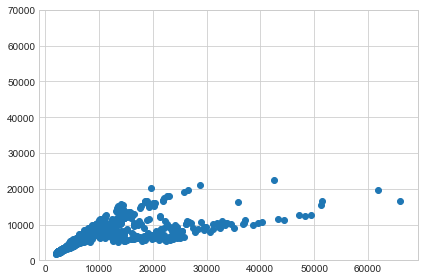

In [37]:
plt.scatter(y_valid, model_3.predict(X_valid_proc))
plt.ylim(0,70000)

It seems that the more complex model is a lot better below 10000. However neither model can handle the very large values very well.

Finally, let's try random forest.

In [39]:
from sklearn.ensemble import RandomForestRegressor

RF_results = pd.DataFrame(columns=['n_est', 'MAE'])

for i in range(20):
    n_est = i+2
    model_RF = RandomForestRegressor(n_estimators=n_est, random_state=0)
    _ = model_RF.fit(X_train_proc, y_train)
    pred_RF = model_RF.predict(X_valid_proc)
    score = mean_absolute_error(y_valid, pred_RF)
    
    RF_results = RF_results.append({'n_est': n_est, 'MAE': score}, ignore_index=True)

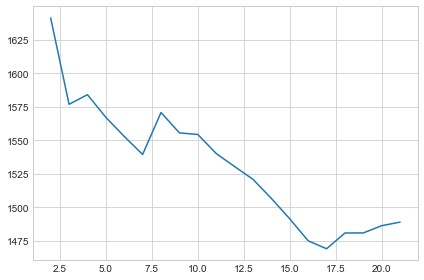

In [40]:
plt.plot(RF_results['n_est'], RF_results['MAE'])
plt.xlim = (3,23)
plt.ylim=(0,1600)

It seems that a random forest with 3 estimators can already yield a reasonable result.

We will record the scores using n=3 and n=16 as the score of random forest.

In [59]:
res_df = res_df.append({'Method': 'Random Forest n=3', 'MAE': RF_results.iloc[1,1]}, ignore_index=True)
res_df = res_df.append({'Method': 'Random Forest n=16', 'MAE': RF_results.iloc[14,1]}, ignore_index=True)

In [60]:
res_df

,Method,MAE
0,Mean Blind Guess,4358.25
1,Multivariate Linear Reg,3924.3
2,NN (3 layers),3423.13
3,NN (4 layers),3428.75
4,NN (6 layers),1914.36
5,Random Forest n=3,1576.9
6,Random Forest n=16,1475.06


Again, check the residuals

TypeError: 'tuple' object is not callable

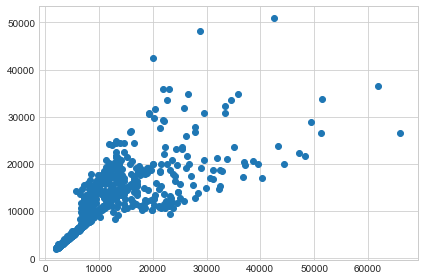

In [64]:
plt.scatter(y_valid, model_RF.predict(X_valid_proc))
plt.ylim(0,70000)

It seems that the random forest model has less underestimation than the NN we have built.

Summary:

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

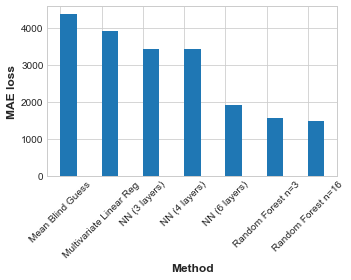

In [65]:
plt.figure(figsize=(5, 4))
plt.bar(res_df['Method'], res_df['MAE'],align='edge', width=0.4)
plt.xlabel('Method')
plt.ylabel('MAE loss')

plt.xticks(rotation=45)

To do:

- Better feature engineering
- Better treatment for date
- Find out if our NN is working properly (the loss vs. epoch curve looks strange)
